<a href="https://colab.research.google.com/github/Da-Heon/MachineLearning/blob/main/%EC%83%81%EA%B4%80%EA%B4%80%EA%B3%84%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install koreanize_matplotlib -q
import koreanize_matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 49.4 MB/s eta 0:00:00


In [4]:
data = load_diabetes(as_frame=True)
df = data.frame  # feature와 target을 포함함 데이터프레임

In [5]:
df

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485,104.0
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491,132.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930,220.0


- 내가 잘 모르는 데이터에서 feature를 이용해야는데 어떻게 할까?
- 음수는 신경쓰지 말자고 가정(절대값 사용)
- 타겟과 상관관계가 있을수록 모델이 잘 예측한다는 뜻! 잘 설명한다는 뜻
    - 0.4 또는 0.3 아래로는 기준을 잡지말자 식으로 세울 수 있음 - 기준성 선정이 중요

In [10]:
# 타겟과의 상관관계를 파악할 수 있음
# 타켓과 각 피처 간 상관계수 계산
corr_with_target = df.corr()['target'].abs().sort_values(ascending=False)

In [16]:
# 0.2 보다 높은 컬럼만 리시트로 뽑아보자
threshold = 0.2
features = corr_with_target[corr_with_target >= threshold].index.drop('target').tolist()

In [17]:
features

['bmi', 's5', 'bp', 's4', 's3', 's6', 's1']

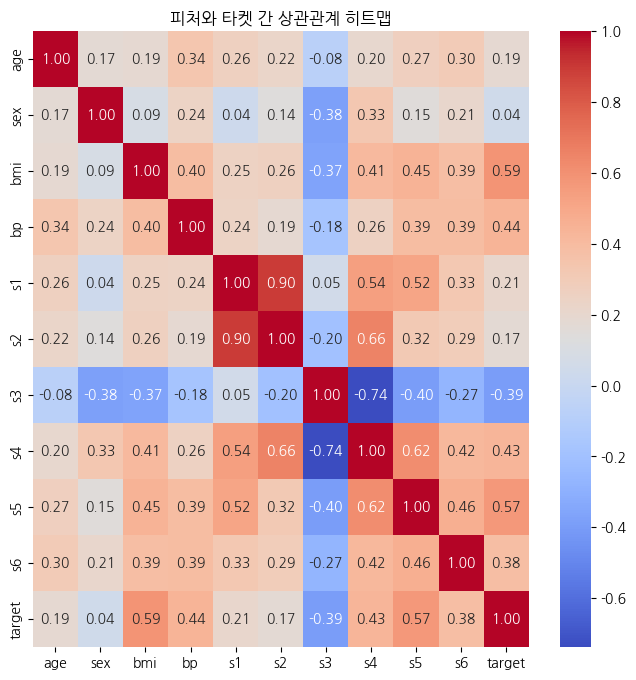

In [20]:
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('피처와 타켓 간 상관관계 히트맵')
plt.show()

- 타겟과 피터와의 관계는 높을수록 좋다
- 피처끼리의 상관관계가 높다는 것은 좋지 않다는 뜻! 서로 연관성이 있어서 다중공선성이 높음! 그래서 모델 해석이 어려움
- 위 상황을 동시에 고려해서 설명력은 살리고, 공선성을 줄이는 선택을 하는 것이 목표
- 우선 사용할 피처
    - bmi, bp, s5
    - 타겟과 상관이 높으면서, 서로 간 상관이 과도하게 높지 않은 피처이기 때문
- 피처 간 다중곤성성 점검
    - s4, s5가 0.62로 높게 상관되어 있어있습니다.
    - 둘 다 타겟 상관관계는 좋지만,
    - 둘 다 동시에 쓰면 계수 추정이 불안정해질 수 있습니다. 그래서 둘 중 하나만 사용해야합니다.
    - 또는 차원축소(PCA)를 적용한 방안을 고려해야 합니다.

## 첫 번째 시도(베이스라인 모델 선정)

In [21]:
# 모든 피처를 사용한 모델
X = df.drop(columns='target')
y = df['target']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=95
)

In [23]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [25]:
y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [26]:
print(f'RMSE: {rmse:.3f}')
print(f'R2: {r2:.3f}')

RMSE: 63.763
R2: 0.409


In [32]:
coef_df = pd.DataFrame({
    'feature' : X.columns,
    'coef' : model.coef_,
    'intercept' : model.intercept_
})
coef_df.sort_values(by='coef', ascending=False).head()

,feature,coef,intercept
8,s5,869.257482,151.76774
5,s2,552.645900,151.76774
2,bmi,431.929952,151.76774
3,bp,415.017500,151.76774
6,s3,111.162642,151.76774


---

# 두 번째 시도

- 기준을 0.2 이상인 컬럼들만 사용(상관관계가 높은 컬럼들만 사용)

In [33]:
threshold = 0.2
features = corr_with_target[corr_with_target >= threshold].index.drop('target').tolist()

In [35]:
# 모든 피처를 사용한 모델
X = df[features]
y = df['target']

In [37]:


X.head(1)

,bmi,s5,bp,s4,s3,s6,s1
0,0.061696,0.019907,0.021872,-0.002592,-0.043401,-0.017646,-0.044223


In [38]:
# 모델 분류하기
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=95
)


# 모델 학습하기
model = LinearRegression()
model.fit(X_train, y_train)


# 모델 평가
y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 그 결과는?
print(f'RMSE: {rmse:.3f}')
print(f'R2: {r2:.3f}')

RMSE: 64.433
R2: 0.397


- 피처를 10개 -> 8개 사용했는데 크게 차이가 없다면?(베이스 라인과)
    - 자원효율을 잘 쓰고 있다는 증거

---

In [47]:
# 기본 피처
base_features = ['bmi', 'bp', 's5']


# 모든 피처
df.columns

Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6',
       'target'],
      dtype='object')

In [48]:
candidates = [
    col for col in df.columns if col not in base_faetures + ['target']
]

candidates

['age', 'sex', 's1', 's2', 's3', 's4', 's6']

In [49]:
results = []

for feature in candidates:
    features = base_features + [feature]
    X = df[features]
    y = df['target']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=45
        )

    # 모델 학습
    model = LinearRegression()
    model.fit(X_train, y_train)

    # 모델 평가
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Added_Feature': feature,
        'RMSE': np.round(rmse, 3),
        'R2': np.round(r2, 3)
    })

result_df = pd.DataFrame(results)
result_df

,Added_Feature,RMSE,R2
0,age,48.792,0.518
1,sex,48.507,0.523
2,s1,48.740,0.519
3,s2,48.794,0.517
4,s3,48.722,0.519
5,s4,49.050,0.512
6,s6,49.119,0.511
